#### 검증 세트를 이용한 과대적합 찾기

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [10]:
print(x_train.shape)

(364, 30)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [12]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = (a - y[i])                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val))

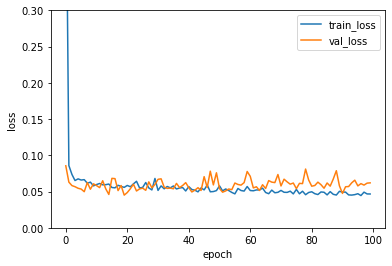

In [13]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### 케라스에 검증 데이터 사용하기

Epoch 1/100
364/364 [==============================] - 0s 803us/step - loss: 0.2353 - accuracy: 0.9258 - val_loss: 0.1460 - val_accuracy: 0.9560
Epoch 2/100
364/364 [==============================] - 0s 705us/step - loss: 0.1347 - accuracy: 0.9615 - val_loss: 0.1129 - val_accuracy: 0.9560
Epoch 3/100
364/364 [==============================] - 0s 680us/step - loss: 0.1123 - accuracy: 0.9670 - val_loss: 0.0990 - val_accuracy: 0.9670
Epoch 4/100
364/364 [==============================] - 0s 677us/step - loss: 0.1002 - accuracy: 0.9725 - val_loss: 0.0914 - val_accuracy: 0.9670
Epoch 5/100
364/364 [==============================] - 0s 667us/step - loss: 0.0933 - accuracy: 0.9725 - val_loss: 0.0851 - val_accuracy: 0.9780
Epoch 6/100
364/364 [==============================] - 0s 675us/step - loss: 0.0881 - accuracy: 0.9753 - val_loss: 0.0802 - val_accuracy: 0.9780
Epoch 7/100
364/364 [==============================] - 0s 663us/step - loss: 0.0842 - accuracy: 0.9753 - val_loss: 0.0762 - val_ac

364/364 [==============================] - 0s 702us/step - loss: 0.0538 - accuracy: 0.9890 - val_loss: 0.0517 - val_accuracy: 0.9890
Epoch 58/100
364/364 [==============================] - 0s 682us/step - loss: 0.0537 - accuracy: 0.9890 - val_loss: 0.0516 - val_accuracy: 0.9890
Epoch 59/100
364/364 [==============================] - 0s 699us/step - loss: 0.0535 - accuracy: 0.9890 - val_loss: 0.0514 - val_accuracy: 0.9890
Epoch 60/100
364/364 [==============================] - 0s 700us/step - loss: 0.0534 - accuracy: 0.9890 - val_loss: 0.0513 - val_accuracy: 0.9890
Epoch 61/100
364/364 [==============================] - 0s 673us/step - loss: 0.0533 - accuracy: 0.9890 - val_loss: 0.0514 - val_accuracy: 0.9890
Epoch 62/100
364/364 [==============================] - 0s 675us/step - loss: 0.0532 - accuracy: 0.9890 - val_loss: 0.0513 - val_accuracy: 0.9890
Epoch 63/100
364/364 [==============================] - 0s 675us/step - loss: 0.0530 - accuracy: 0.9890 - val_loss: 0.0513 - val_accuracy

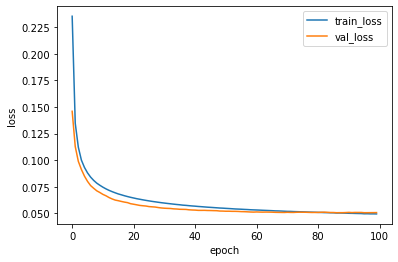

In [14]:
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense      # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers        # 케라스의 옵티마이저를 임포트
import numpy as np # Numpy를 임포트
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
test_size=0.2, random_state=42)

layer = preprocessing.Normalization()
layer.adapt(x_train) # 메서드를 통해 전처리 레이어의 상태를 훈련 데이터에 노출함으로써 상태를 설정할 수 있습니다.

model=Sequential()
model.add(layer)
model.add(Dense(1, input_dim=30, activation='sigmoid'))
SGD=optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=SGD ,loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=1, epochs=100, shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()